In [8]:
import os
os.environ["SPARKMONITOR_DISABLED"] = "1"

In [5]:
import sys
!{sys.executable} -m pip install scikit-learn

## 6.3.1 2つの月のデータセット

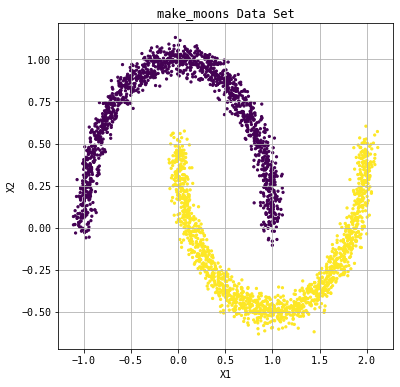

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=3000, noise=0.05)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=5)
plt.title("make_moons Data Set")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

In [25]:
import sklearn
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras.layers import Normalization

data = datasets.make_moons(3_000, noise = 0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

## 6.3.2 カップリング層

In [27]:
# Keras のカップリング層
def Coupling():
    input_layer = layers.Input(shape = 2)
    
    s_layer_1 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(input_layer)

    s_layer_2 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_1)

    s_layer_3 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_2)

    s_layer_4 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_3)

    s_layer_5 = layers.Dense(
        256,
        activation         = "tanh", 
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)    
    )(input_layer)
    
    t_layer_2 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)    
    )(t_layer_1)

    t_layer_3 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)    
    )(t_layer_2)

    t_layer_4 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)    
    )(t_layer_3)

    t_layer_5 = layers.Dense(
        256,
        activation         = "linear", # 線形関数
        kernel_regularizer = regularizers.l2(0.01)    
    )(t_layer_4)

    return models.Model(inputs = input-layer, outputs = [s_layer_5, t_layer_5])

$$
tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

### 6.3.2.1 カップリング層にデータを渡す

### 6.3.2.2 カップリング層を積み重ねる

- 問題：入力の最初の d 個の要素をどのように更新すればよいか？
- 解決：ある層によって変更されなかった次元も、マスキングパターンを変えてカップリング層を積み重ねると次の層では更新される
    - 付加的な利点：ニューラルネットワークが深くなるため、より複雑な表現を学習できる

- **Jacobi 行列は簡単なまま**
    - ∵ 行列の積の行列式 = 各行列の行列式の積
$$
det(A \cdot B) = det(A) det(B)
$$
- **合成関数の逆関数 = 逆関数の合成関数**
$$
(f_b \circ f_a) = f_a^{-1} \circ f_b^{-1}
$$

## 6.3.3 Real NVP モデルを訓練する

- 目的：生成されたデータの負の対数尤度を最小化すること

- 式 6-1
$$
p_X(x) = p_Z(z) \left| { det \left( \frac{\partial z}{\partial x} \right) } \right|
$$

- を用いると
$$
-\log{p_X(x)} = -\log{p_Z(x)} - \log{\left| { det \left( \frac{\partial z}{\partial x} \right) } \right|}
$$

In [ ]:
conda install -c conda-forge cmake


# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/miniconda/lib/python3.11/site-packages/conda/exception_handler.py", line 16, in __call__
        return func(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^
      File "/opt/miniconda/lib/python3.11/site-packages/conda/cli/main.py", line 84, in main_subshell
        exit_code = do_call(args, p)
                    ^^^^^^^^^^^^^^^^
      File "/opt/miniconda/lib/python3.11/site-packages/conda/cli/conda_argparse.py", line 126, in do_call
        return getattr(module, func_name)(args, parser)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      File "/opt/miniconda/lib/python3.11/site-packages/conda/notices/core.py", line 123, in wrapper
        return func(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^
      File "/opt/miniconda/lib/python3.11/site-packages/conda/cli/main_install.py", line 22, in execute
        install(args, parser, "install")
   

In [35]:
!{sys.executable} -m pip install tensorflow_probability==0.11.1

     |████████████████████████████████| 4.3 MB 676 kB/s eta 0:00:011
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached dm-tree-0.1.8.tar.gz (35 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/miniconda/envs/py36/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-tujh1k_j/dm-tree_5fa1b43393c04f48bd2e45304b71e66b/setup.py'"'"'; __file__='"'"'/tmp/pip-install-tujh1k_j/dm-tree_5fa1b43393c04f48bd2e45304b71e66b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-53h5b_71
       cwd: /tmp/pip-install-tujh1k_j/dm-tree_5fa1b43393c04f48bd2e45304b71e66b/
  Complete output (55 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  cre

In [33]:
# Keras の Model をカスタマイズして Real NVP ネットワークを作成する

from tensorflow.keras import models
import tensorflow_probability as tfp

class RealNVP(models.Model):
    def __init__(
        self,
        input_dim,
        coupling_layers,
        coupling_dim,
        regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc        = [0.0, 0.0],
            scale_diag = [1.0, 1.0]
        )
        self.masks = np.array(
            [ [0, 1], [1, 0] ] * (coupling_layers // 2),
            dtype = "float32"
        )
        self.loss_tracker = metrics.Mean(name = "loss")
        self.layers_list = [
            Coupling(
                input_dim,
                coupling_dim,
                regularization
                )
        ]
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def call(self, x, training = True):
        log_det_inv = 0
        direction   = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]: # ::1なら順方向 / ::-1 なら逆方向
            x_masked      = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t          = self.layers_list[i](x_masked)
            s            *= reversed_mask # s = s * reversed_mask
            t            *= reversed_mask # t = t * reversed_mask
            gate          = ( direction - 1 ) / 2
            x             = (
                            reversed_mask * (
                                x * tf.exp(direction * s)
                                + direction * t * tf.exp(gate * s)
                                            )
                                
                            )
            log_det_inv  += gate * tf.reduce_sum(s, axis = 1)
        return x, log_det_inv
    
    def log_loss(self, x):
        y, logdet      = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = RealNVP(
    input_dim       = 2,
    coupling_layers = 6,
    coupling_dim    = 256,
    regularization  = 0.01
)

model.compile(optimizer = optimizers.Adam(learning_rate = 0.0001))

model.fit(
    normalized_data,
    batch_size = 256,
    epochs     = 300
)

ModuleNotFoundError: No module named 'tensorflow_probability'

## 6.3.4 Real NVP モデルの分析